In [4]:
import matplotlib.pyplot as plt
import uproot
import numpy as np
import pandas as pd

from pathlib import Path
from sklearn.model_selection import train_test_split

from datetime import datetime
import sys
sys.path.insert(1, '/afs/desy.de/user/a/axelheim/private/MC_studies/Dstlnu_Bt_generic/util_funcs/')
from pandas_colFuncs import isBtoDstlnu, whichBisSig, customMCmatching, B_ID

In [5]:
root_path_finalDF = "/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_CMvars_run1/"

## load my6modes dataframe

In [6]:
root_path_my6modesDF ="/nfs/dust/belle2/user/axelheim/MC_studies/Dstlnu_Bt_generic/SHR_Hc_correctReco_BsX/SHR_dataSteering_run1/"
my6modes_df = pd.read_csv(root_path_my6modesDF + "df_my6modes.csv")

In [7]:
my6modes_df['label'].unique()

array([1, 2, 3, 0])

In [8]:
#cut out Hc particles

In [9]:
my6modes_df = my6modes_df[my6modes_df['label'] != 3]

## load the D*lnu dataframe

In [10]:
df_FSPs = pd.read_csv(root_path_finalDF + "final_df_FSPs_preProcessed_SHR.csv")
df_Y4S = pd.read_csv(root_path_finalDF + "final_df_Y4S_preProcessed_SHR.csv")

In [11]:
def labels(s):
    label = -1
    if int(s['B_ID']) == 0:
        label = 0 # background, cause not related to MC Particles
    else: 
        event_num = (s['__event__'])
        B_sigID = df_Y4S[df_Y4S['__event__'] == event_num].iloc[0]['Bsig_uniqParID']
        
        if int(s['B_ID']) == B_sigID:
            label = 2 # Bsig
        else:
            label = 1 #X
    return label

In [12]:
df_FSPs['label'] = df_FSPs.apply(labels, axis=1)

In [13]:
df_FSPs['label'].unique()

array([1, 2, 0])

## save FSPs with labels, take too much time 

In [14]:
df_FSPs.to_csv(root_path_finalDF + "final_df_FSPs_preProcessed_SHR_wLabels.csv")

In [15]:
df_FSPs = pd.read_csv(root_path_finalDF + "final_df_FSPs_preProcessed_SHR_wLabels.csv")

## start analysis

In [16]:
df_FSPs["absPDG"] = df_FSPs["PDG"].abs()
df_FSPs["absPDG"].unique()

array([211.,  11.,  22., 321.,  13.])

In [17]:
df_FSPs_neutrals = df_FSPs[df_FSPs["absPDG"] == 22.]
df_FSPs_charged = df_FSPs[df_FSPs["absPDG"] != 22.]

In [18]:
numFSPs = pd.DataFrame({'count' : df_FSPs.groupby( ["__event__"] ).size()}).reset_index()
numFSPsmy6modes = pd.DataFrame({'count' : my6modes_df.groupby( ["event","mode"] ).size()}).reset_index()

In [19]:
numFSPs_neutrals = pd.DataFrame({'count' : df_FSPs_neutrals.groupby( ["__event__"] ).size()}).reset_index()
numFSPs_charged = pd.DataFrame({'count' : df_FSPs_charged.groupby( ["__event__"] ).size()}).reset_index()

In [20]:
numEvents_my6modes = numFSPsmy6modes.shape[0]
numEvents_Dstlnu = numFSPs.shape[0]


print("numEvents D*lnu:", numEvents_Dstlnu)
print("numEvents my6modes:", numEvents_my6modes)

numEvents D*lnu: 51177
numEvents my6modes: 89991


In [21]:
numFSPs_neutrals2 = pd.DataFrame({'count' : df_FSPs_neutrals.groupby( ["__event__","label"] ).size()}).reset_index()
numFSPs_charged2 = pd.DataFrame({'count' : df_FSPs_charged.groupby( ["__event__","label"] ).size()}).reset_index()

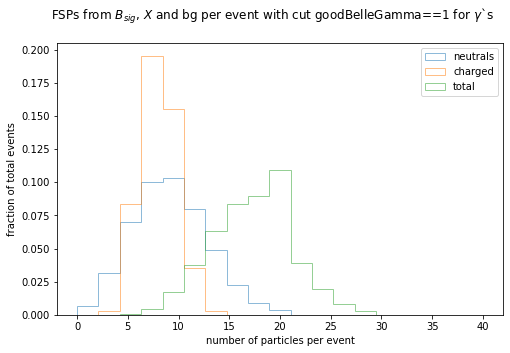

In [28]:
bins = np.linspace(0, 40, 20)
fig, ax = plt.subplots()
fig.suptitle(r'FSPs from $B_{sig}$, ${X}$ and bg per event with cut goodBelleGamma==1 for $\gamma$`s')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of particles per event')
ax.set_ylabel("fraction of total events")

ax.hist(numFSPs_neutrals["count"],bins=bins,density=True, alpha=0.5, label=(r'neutrals'),histtype='step')
ax.hist(numFSPs_charged["count"],bins=bins,density=True, alpha=0.5, label=(r'charged'),histtype='step')
ax.hist(numFSPs["count"],bins=bins,density=True, alpha=0.5, label=(r'total'),histtype='step')




ax.legend(loc='upper right')

plt.savefig('dataSetAnaPlots/numFSPs_histo_SHR_CMvarsrun1_neutrals_charged.pdf')

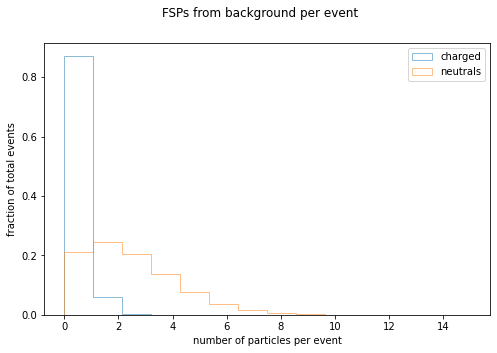

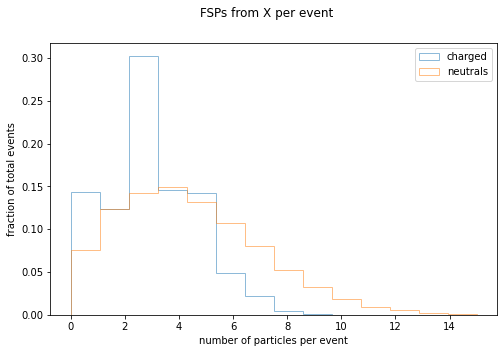

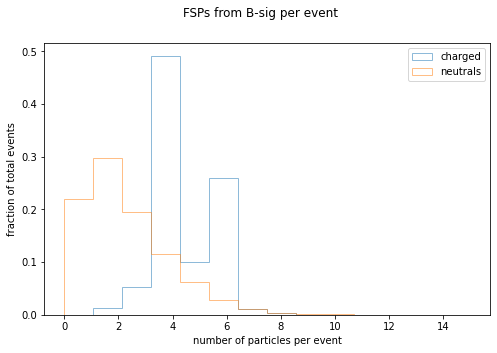

In [30]:
label_cat = {0: "background",1: "X",2: "B-sig"}

for label in [0,1,2]:

    bins = np.linspace(0, 15, 15)
    fig, ax = plt.subplots()
    fig.suptitle(f'FSPs from {label_cat[label]} per event')
    fig.set_size_inches(8, 5)

    ax.set_xlabel(r'number of particles per event')
    ax.set_ylabel("fraction of total events")
    
    ax.hist(numFSPs_charged2[numFSPs_charged2["label"] == label]["count"],bins=bins,density=True, alpha=0.5, label=(r'charged'),histtype='step')
    ax.hist(numFSPs_neutrals2[numFSPs_neutrals2["label"] == label]["count"],bins=bins,density=True, alpha=0.5, label=(r'neutrals'),histtype='step')


    ax.legend(loc='upper right')
    plt.savefig(f'dataSetAnaPlots/numFSPs_histo_SHR_CMvarsrun1_cuts_{label_cat[label]}.pdf')

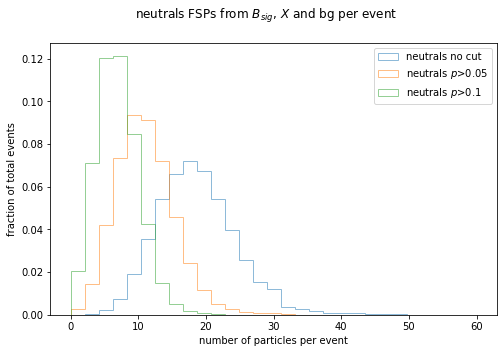

In [92]:
bins = np.linspace(0, 60, 30)
fig, ax = plt.subplots()
fig.suptitle(r'neutrals FSPs from $B_{sig}$, ${X}$ and bg per event')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of particles per event')
ax.set_ylabel("fraction of total events")

ax.hist(numFSPs_neutrals["count"],bins=bins,density=True, alpha=0.5, label=(r'neutrals no cut'),histtype='step')



cuts=[0.050,0.100]
for cut in cuts:
    neutrals_cut = df_FSPs_neutrals[df_FSPs_neutrals["p"] > cut]
    numFSPs_CUTneutrals = pd.DataFrame({'count' : neutrals_cut.groupby( ["__event__"] ).size()}).reset_index()
    ax.hist(numFSPs_CUTneutrals["count"],bins=bins,density=True, alpha=0.5, label=((r'neutrals $p$>{}').format(cut)),histtype='step')



ax.legend(loc='upper right')

plt.savefig('dataSetAnaPlots/numFSPs_histo_SHR_run1data_neutralsCuts.pdf')

In [1]:
bins = np.linspace(0, 20, 20)
fig, ax = plt.subplots()
fig.suptitle(r'charged FSPs from $B_{sig}$, ${X}$ and bg per event')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of particles per event')
ax.set_ylabel("fraction of total events")

ax.hist(numFSPs_charged["count"],bins=bins,density=True, alpha=0.5, label=(r'charged'),histtype='step')



cuts=[0.050,0.100]
for cut in cuts:
    charged_cut = df_FSPs_charged[df_FSPs_charged["p"] > cut]
    numFSPs_CUTcharged = pd.DataFrame({'count' : charged_cut.groupby( ["__event__"] ).size()}).reset_index()
    ax.hist(numFSPs_CUTcharged["count"],bins=bins,density=True, alpha=0.5, label=((r'charged $p$>{}').format(cut)),histtype='step')



ax.legend(loc='upper right')

plt.savefig('dataSetAnaPlots/numFSPs_histo_SHR_run1data_chargedCuts.pdf')

NameError: name 'np' is not defined

In [ ]:
bins = np.linspace(0, 50, 25)
fig, ax = plt.subplots()
fig.suptitle(r'all FSPs per event for $B_{sig}$-$X$ and background')
fig.set_size_inches(8, 5)

ax.set_xlabel(r'number of particles per event')
ax.set_ylabel("fraction of total events")

ax.hist(numFSPs["count"],bins=bins,density=True, alpha=0.5, label=(r'$D* l \nu$ data no cuts'),histtype='step')


df_FSPs_100cut = df_FSPs[df_FSPs["p"] > 0.100]
numFSPsCUT = pd.DataFrame({'count' : df_FSPs_100cut.groupby( ["__event__"] ).size()}).reset_index()
ax.hist(numFSPsCUT["count"],bins=bins,density=True, alpha=0.5, label=(r'$D* l \nu$ data only neutrals p>100MeV'),histtype='step')
df_FSPs_50cut = df_FSPs[df_FSPs["p"] > 0.050]
numFSPsCUT = pd.DataFrame({'count' : df_FSPs_50cut.groupby( ["__event__"] ).size()}).reset_index()
ax.hist(numFSPsCUT["count"],bins=bins,density=True, alpha=0.5, label=(r'$D* l \nu$ data only neutrals p>50MeV'),histtype='step')
ax.hist(numFSPsmy6modes["count"],bins=bins,density=True, alpha=0.5, label=(r'my 6 modes data'),histtype='step')

ax.legend(loc='upper right')

plt.savefig('dataSetAnaPlots/numFSPs_histo_SHR_run1data.pdf')

In [39]:
df_FSPs.keys()

Index(['Unnamed: 0', 'Unnamed: 0.1', '__experiment__', '__run__', '__event__',
       '__candidate__', '__ncandidates__', '__weight__', 'basf2_X',
       'basf2_used', 'basf2_Bsig', 'isSignal', 'uniqueParticleIdentifier',
       'mcErrors', 'mcPDG', 'genMotherID', 'genMotherP', 'genMotherPDG', 'px',
       'py', 'pz', 'pt', 'p', 'E', 'kaonID', 'pionID', 'genMothPDG_0',
       'genMothPDG_1', 'genMothPDG_2', 'genMothPDG_3', 'genMothPDG_4',
       'genMothPDG_5', 'genMothPDG_6', 'genMothPDG_7', 'genMothPDG_8',
       'genMothPDG_9', 'genMotherID_0', 'genMotherID_1', 'genMotherID_2',
       'genMotherID_3', 'genMotherID_4', 'genMotherID_5', 'genMotherID_6',
       'genMotherID_7', 'genMotherID_8', 'genMotherID_9',
       'mcMother0_uniqParID', 'mcMother1_uniqParID', 'mcMother2_uniqParID',
       'mcMother3_uniqParID', 'mcMother4_uniqParID', 'mcMother5_uniqParID',
       'mcMother6_uniqParID', 'mcMother7_uniqParID', 'mcMother8_uniqParID',
       'mcMother9_uniqParID', 'PDG', 'B_ID', 'numFS

array([211.,  11.,  22., 321.,  13.])